<a href="https://colab.research.google.com/github/sebastianrpo/SPIII_MiniP1/blob/main/MP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-proyecto 1: Análisis Multivariado de Señales Sismográficas**
##### Tratamiento de Señales III
##### Facultad de Ingeniería
##### Universidad de Antioquia
##### Daniela Acevedo Zuluaga - Sebastian Restrepo Valencia
##### 2023-1

## 1. Carga de archivos e importación de librerías

In [1]:
!wget "https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisLoc.mat?raw=true" -O "sisLoc.mat"
!wget "https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisReg.mat?raw=true" -O "sisReg.mat"
!wget "https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisTele.mat?raw=true" -O "sisTele.mat"

--2023-03-24 01:54:12--  https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisLoc.mat?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/sebastianrpo/SPIII_MiniP1/raw/main/sisLoc.mat [following]
--2023-03-24 01:54:12--  https://github.com/sebastianrpo/SPIII_MiniP1/raw/main/sisLoc.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sebastianrpo/SPIII_MiniP1/main/sisLoc.mat [following]
--2023-03-24 01:54:12--  https://raw.githubusercontent.com/sebastianrpo/SPIII_MiniP1/main/sisLoc.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting resp

In [2]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd       
import seaborn as sns              
import scipy.io as sc
from pyts.decomposition import SingularSpectrumAnalysis
from scipy.signal import stft, bode, butter, lfilter, freqz

(Text(0.5, 0, 'sample'), Text(0, 0.5, '$\\mu$ V'))

<Figure size 432x288 with 0 Axes>

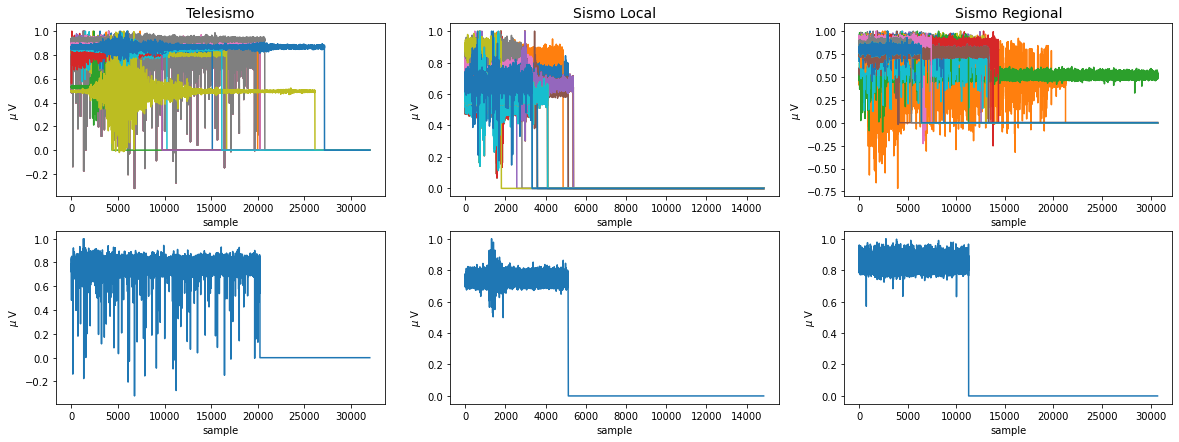

In [8]:
data = sc.loadmat('sisTele.mat')
data.keys() # variables del diccionario
TeleSignal = data['Y']
fs = data['fs']
plt.figure()
plt.figure(figsize=(20,7))
plt.subplot(2, 3, 1)
plt.plot(TeleSignal.T)
plt.title("Telesismo", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

data = sc.loadmat('sisLoc.mat')
data.keys() # variables del diccionario
LocSignal = data['Y']
plt.subplot(2, 3, 2)
plt.plot(LocSignal.T)
plt.title("Sismo Local", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

data = sc.loadmat('sisReg.mat')
data.keys() # variables del diccionario
RegSignal = data['Y']
plt.subplot(2, 3, 3)
plt.plot(RegSignal.T)
plt.title("Sismo Regional", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

idSignal = 0 #Identificador de la señal seleccionada (de las 21).
plt.subplot(2, 3, 4)
plt.plot(TeleSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

plt.subplot(2, 3, 5)
plt.plot(LocSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

plt.subplot(2, 3, 6)
plt.plot(RegSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

In [ ]:
#Funciones para la implementación del filtro pasabandas.
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y